# Train TSLA Model
This notebook will develop and train a neural network to predict the percent change in the TSLA price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'TSLA'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,1.110920,3.621683,2.360663,0.309431,-17.938857,-1.694647,525.916372,-1156.897541,1.101679,1.075658,...,97.0,155.0,1568.0,425.0,0.125475,0.505703,0.368821,0.070136,0.709502,0.192308
2021-03-02,-1.227996,3.596825,2.346563,-0.120497,-22.722984,-1.701266,34.786619,-1059.164814,0.535303,0.947017,...,135.0,277.0,704.0,621.0,0.112299,0.526738,0.360963,0.152198,0.386813,0.341209
2021-03-03,-1.358152,3.564533,2.328616,-0.528847,-29.193237,-1.684017,-967.564976,-1100.532684,-2.233465,0.947017,...,180.0,414.0,1708.0,1733.0,0.112403,0.538760,0.348837,0.107171,0.442143,0.448615
2021-03-04,-1.317588,3.536505,2.289451,-0.572361,-45.279830,-1.726109,-968.619080,-1271.406022,-4.099723,0.947017,...,210.0,545.0,1901.0,1253.0,0.126095,0.506130,0.367776,0.145839,0.508697,0.335296
2021-03-05,-1.187882,3.569409,2.236338,-0.350941,-59.129472,-1.775831,-1110.304378,-1420.299037,-5.764388,0.947017,...,199.0,417.0,2226.0,1202.0,0.100494,0.571664,0.327842,0.104172,0.556083,0.300275
2021-03-08,0.318562,3.518555,2.205570,-0.676407,-68.195210,-1.794279,152.478191,-1424.743206,-5.609578,0.785673,...,212.0,531.0,2511.0,1508.0,0.130081,0.525203,0.344715,0.112500,0.531992,0.319492
2021-03-09,4.229347,3.587047,2.245687,-0.186914,13.784729,-1.388916,1286.971678,-958.431468,8.846391,0.785673,...,246.0,459.0,2991.0,2232.0,0.098257,0.511886,0.389857,0.079138,0.515690,0.384828
2021-03-10,-0.075724,3.546629,2.209680,-0.402159,8.577071,-1.062301,1146.490836,-729.193360,11.044357,0.764373,...,118.0,182.0,1391.0,709.0,0.069401,0.558360,0.372240,0.074286,0.567755,0.289388
2021-03-11,-1.224214,3.578441,2.231219,-0.030976,18.412720,-0.862833,52.493613,-725.650912,1.010536,0.886072,...,108.0,651.0,1248.0,581.0,0.094118,0.588235,0.317647,0.245475,0.470588,0.219080


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 43s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 10s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 12s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 15s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 21s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 27s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 12s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 15s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|

Training complete in 0m 11s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 22s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 28s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 9s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 23s
Iteration: 90 |periods: 60|hidden:

Training complete in 0m 13s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 16s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 23s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 31s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 12s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 15s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 20s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 30s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 41s
Iteration: 169 |periods: 1|

Training complete in 0m 18s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 27s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 38s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 11s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 14s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 19s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 29s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 40s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 248 |periods: 5|hidd

Training complete in 0m 20s
Iteration: 317 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 30s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 39s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 12s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 21s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 33s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 46s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 8s
Iteration: 326 |periods: 5|

Training complete in 0m 31s
Iteration: 396 |periods: 60|hidden: 100|layers: 3|drop: 0.25|lr: 0.01|clip: 5
Training complete in 0m 43s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 8s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 10s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 18s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 23s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 8s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 9s
Iteration: 405 |periods: 10|hidden: 50|lay

Training complete in 0m 23s
Iteration: 475 |periods: 1|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 9s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 11s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 14s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 19s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 24s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 10s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 11s
Iteration: 48

Training complete in 0m 23s
Iteration: 553 |periods: 1|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 14s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 21s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 27s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 10s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 562 |periods: 20|

Training complete in 0m 26s
Iteration: 631 |periods: 1|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 632 |periods: 5|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 10s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 13s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 27s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 36s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 10s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 13s
Iteration: 640 |periods: 20|hidde

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

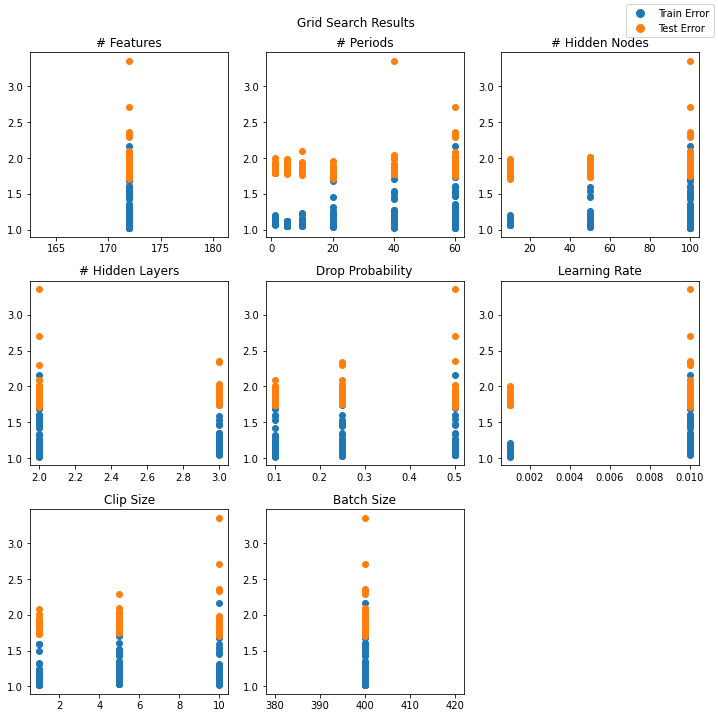

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
615,1.092821,1.710886,172.0,20.0,10.0,2.0,0.50,0.010,10.0,400.0
543,1.077758,1.733723,172.0,20.0,10.0,2.0,0.10,0.010,10.0,400.0
27,1.069659,1.736070,172.0,20.0,50.0,3.0,0.10,0.001,1.0,400.0
9,1.058800,1.736611,172.0,20.0,50.0,2.0,0.10,0.001,1.0,400.0
305,1.047573,1.743073,172.0,60.0,100.0,2.0,0.50,0.001,5.0,400.0
...,...,...,...,...,...,...,...,...,...,...
377,1.951998,2.293979,172.0,60.0,100.0,2.0,0.25,0.010,5.0,400.0
611,1.734171,2.333859,172.0,60.0,100.0,3.0,0.25,0.010,10.0,400.0
647,1.475210,2.357087,172.0,60.0,100.0,3.0,0.50,0.010,10.0,400.0
629,2.160183,2.704641,172.0,60.0,100.0,2.0,0.50,0.010,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [19]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [20]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 36 different configurations.
Iteration: 1 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 4m 11s
Iteration: 2 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 59s
Iteration: 3 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 59s
Iteration: 4 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 22s
Iteration: 5 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 6 |epochs: 10|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 7 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 10m 19s
Iteration: 8 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 5m 6s
Iteration: 9 |epochs: 25|perio

In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

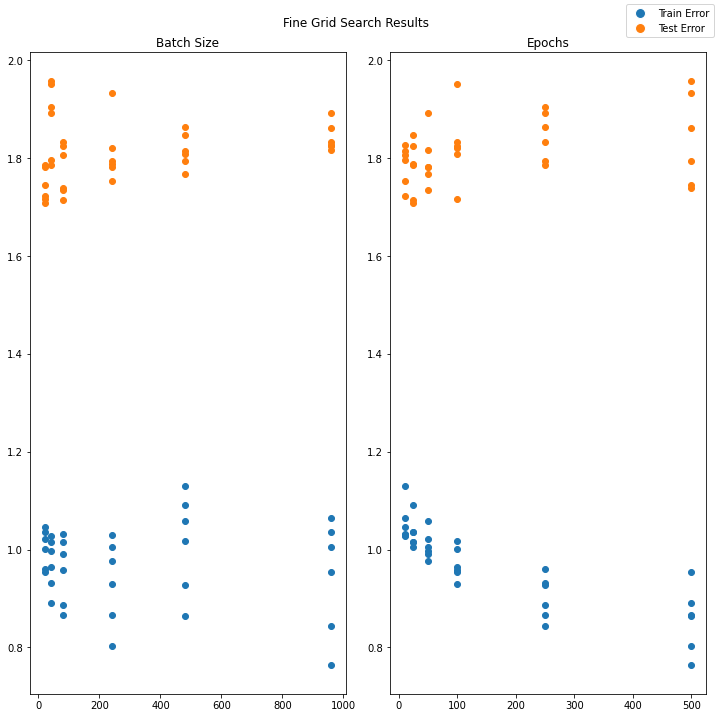

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
6,1.036646,1.707458,172.0,20.0,10.0,2.0,0.5,0.01,10.0,20.0,25.0
8,1.015146,1.715209,172.0,20.0,10.0,2.0,0.5,0.01,10.0,80.0,25.0
18,1.001703,1.715923,172.0,20.0,10.0,2.0,0.5,0.01,10.0,20.0,100.0
0,1.045174,1.723251,172.0,20.0,10.0,2.0,0.5,0.01,10.0,20.0,10.0
14,0.991658,1.733652,172.0,20.0,10.0,2.0,0.5,0.01,10.0,80.0,50.0
32,0.866652,1.738185,172.0,20.0,10.0,2.0,0.5,0.01,10.0,80.0,500.0
30,0.953329,1.744869,172.0,20.0,10.0,2.0,0.5,0.01,10.0,20.0,500.0
3,1.030696,1.753035,172.0,20.0,10.0,2.0,0.5,0.01,10.0,240.0,10.0
16,1.059378,1.767169,172.0,20.0,10.0,2.0,0.5,0.01,10.0,480.0,50.0
12,1.021469,1.782008,172.0,20.0,10.0,2.0,0.5,0.01,10.0,20.0,50.0


## Evaluate Final Model

In [10]:
#best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(6+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

Training RMSE: 6.367265861778828
Test RMSE: 30.457774718614388
Training MAE: 2.129850960521264
Test MAE: 24.650430863928285
Training - Above Error: $2.41 (41.89%) Below Error: $-1.92 (58.11%)
Test - Above Error: $27.96 (37.84%) Below Error: $-22.64 (62.16%)


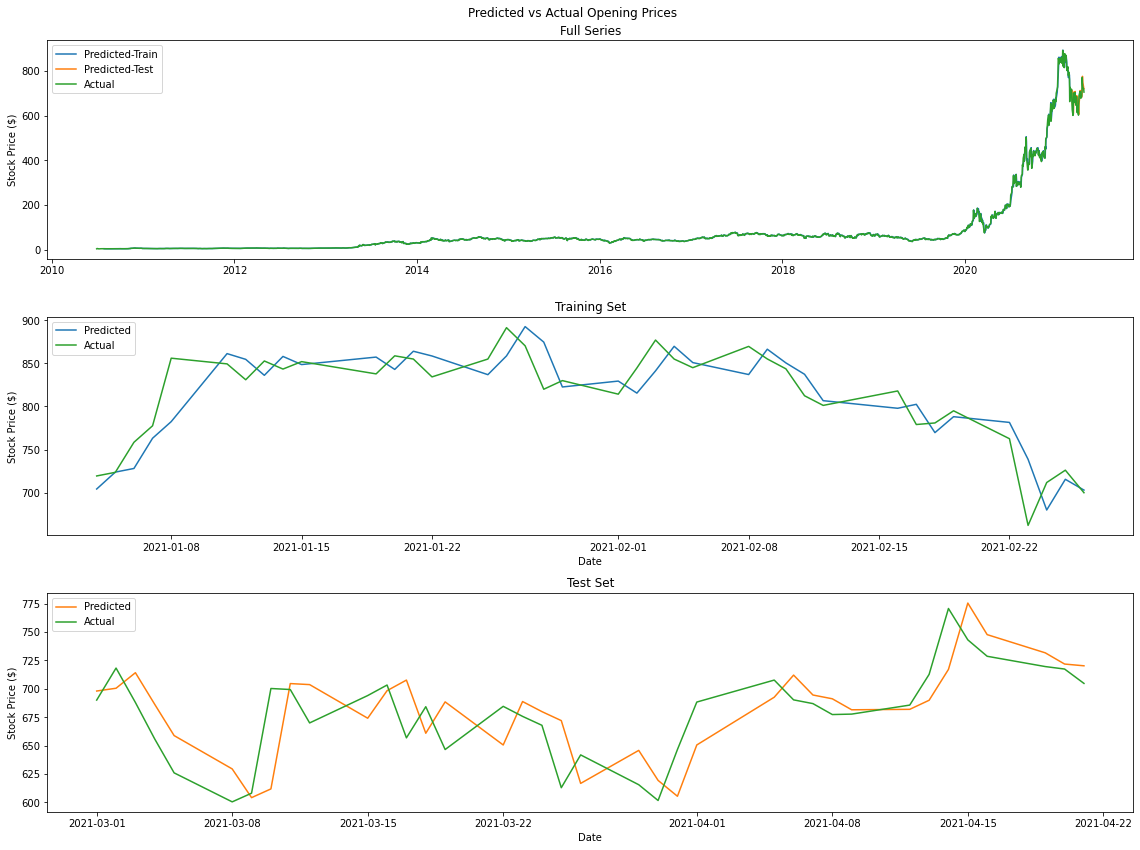

In [11]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [12]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,743.099976,0.006186,Test,775.467321
2021-04-16,728.650024,0.004165,Test,747.696559
2021-04-19,719.599976,0.003076,Test,731.684679
2021-04-20,717.419983,0.003972,Test,721.813618
2021-04-21,704.770020,0.001969,Test,720.269437


In [28]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [29]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)

In [13]:
preds = dh.predict(model,df,output_data[:-1],scaler,model.n_periods,1,1)

In [14]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,743.099976,0.006186,Training,775.467321
2021-04-16,728.650024,0.004165,Training,747.696559
2021-04-19,719.599976,0.003076,Training,731.684679
2021-04-20,717.419983,0.003972,Training,721.813618
2021-04-21,704.770020,0.001969,Test,720.269437


In [15]:
df

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,10.032261,-0.275947,-0.786688,3.586303,-0.012183,-0.263937,-0.035945,-0.042520,-76.561461,0.112212,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-06-30,-0.902813,-0.359199,-0.837745,-0.330243,-0.082022,1.747889,0.375691,1.224450,-76.868620,0.107376,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-01,-2.294158,-0.377991,-0.862160,-0.684996,-0.220739,0.557331,-0.496021,-0.117065,-3.033554,-0.043349,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-02,-3.715568,-0.400713,-0.877429,-1.052877,-0.328192,0.154712,-0.368442,-0.433345,-5.651810,-0.265811,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-06,-5.112472,-0.434545,-0.897828,-1.496666,-0.488336,-0.183484,-0.358699,-0.583988,-7.650585,-0.265811,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15,-0.587541,3.667809,2.291813,-0.014334,16.738136,0.341181,-391.263388,545.315031,-1.506820,0.735604,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-16,-0.389549,3.674919,2.308403,0.277973,14.596498,0.606560,88.899759,600.730216,0.204413,0.735604,...,78.0,308.0,847.0,446.0,0.183673,0.497959,0.318367,0.184100,0.506276,0.266587
2021-04-19,-0.124885,3.691132,2.284825,0.104551,2.852985,0.511377,-534.390200,537.715909,-1.186305,0.735604,...,78.0,302.0,931.0,502.0,0.175299,0.513944,0.310757,0.167499,0.516362,0.278425


In [16]:
output_data[:-1]

,Open
Date,
2010-06-29,3.800000
2010-06-30,5.158000
2010-07-01,5.000000
2010-07-02,4.600000
2010-07-06,4.000000
...,...
2021-04-15,743.099976
2021-04-16,728.650024
2021-04-19,719.599976


In [17]:
scaler

RobustScaler()

In [18]:
scaler.__dict__

{'with_centering': True,
 'with_scaling': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'copy': True,
 'n_features_in_': 1,
 'center_': array([0.00140176]),
 'scale_': array([0.0354822])}

In [19]:
model.n_periods

20